<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Randomized Benchmarking Overview

### Contributors

Shelly Garion$^{1}$, Yael Ben-Haim$^{1}$ and David McKay$^{2}$

1. IBM Research Haifa, Haifa University Campus, Mount Carmel Haifa, Israel
2. IBM T.J. Watson Research Center, Yorktown Heights, NY, USA


## Introduction

One of the main challenges in building a quantum information processor is the non-scalability of completely
characterizing the noise affecting a quantum system via process tomography. In addition, process tomography is sensitive to noise in the pre- and post rotation gates plus the measurements (SPAM errors). Gateset tomography can take these errors into account, but the scaling is even worse.  A complete characterization
of the noise is useful because it allows for  the determination of good error-correction schemes, and thus
the possibility of reliable transmission of quantum information.

Since complete process tomography is infeasible for large systems, there is growing interest in scalable
methods for partially characterizing the noise affecting a quantum system. A scalable (in the number $n$ of qubits comprising the system) and robust algorithm for benchmarking the full set of Clifford gates by a single parameter using randomization techniques was presented in [1]. The concept of using randomization methods for benchmarking quantum gates is commonly called **Randomized Benchmarking
(RB)**.


### References

1. Easwar Magesan, J. M. Gambetta, and Joseph Emerson, *Robust randomized benchmarking of quantum processes*,
https://arxiv.org/pdf/1009.3639

2. Easwar Magesan, Jay M. Gambetta, and Joseph Emerson, *Characterizing Quantum Gates via Randomized Benchmarking*,
https://arxiv.org/pdf/1109.6887

3. A. D. C'orcoles, Jay M. Gambetta, Jerry M. Chow, John A. Smolin, Matthew Ware, J. D. Strand, B. L. T. Plourde, and M. Steffen, *Process verification of two-qubit quantum gates by randomized benchmarking*, https://arxiv.org/pdf/1210.7011

4. Jay M. Gambetta, A. D. C´orcoles, S. T. Merkel, B. R. Johnson, John A. Smolin, Jerry M. Chow,
Colm A. Ryan, Chad Rigetti, S. Poletto, Thomas A. Ohki, Mark B. Ketchen, and M. Steffen,
*Characterization of addressability by simultaneous randomized benchmarking*, https://arxiv.org/pdf/1204.6308

5. David C. McKay, Sarah Sheldon, John A. Smolin, Jerry M. Chow, and Jay M. Gambetta, *Three Qubit Randomized Benchmarking*, https://arxiv.org/pdf/1712.06550

## The Randomized Benchmarking Protocol

A RB protocol (see [1,2]) consists of the following steps:

(We should first import the relevant qiskit classes for the demonstration).

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

### Step 1: Generate RB sequences

The RB sequences consist of random Clifford elements chosen uniformly from the Clifford group on $n$-qubits, 
including a computed reversal element,
that should return the qubits to the initial state.

More precisely, for each length $m$, we choose $K_m$ RB sequences. 
Each such sequence contains $m$ random elements $C_{i_j}$ chosen uniformly from the Clifford group on $n$-qubits, and the $m+1$ element is defined as follows: $C_{i_{m+1}} = (C_{i_1}\cdot ... \cdot C_{i_m})^{-1}$. It can be found efficiently by the Gottesmann-Knill theorem.

For example, we generate below several sequences of 2-qubit Clifford circuits.

In [2]:
#Generate RB circuits (2Q RB)

#number of qubits
nQ=2 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 5 
#Default pattern
rb_opts['rb_pattern'] = [[0,1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first RB sequence

In [3]:
print(rb_circs[0][0])

          ┌───┐ ┌───┐     ┌───┐      ░      ┌───┐     ┌─────┐┌───┐┌─┐   
qr_0: |0>─┤ H ├─┤ S ├──■──┤ X ├──────░──────┤ X ├──■──┤ Sdg ├┤ H ├┤M├───
         ┌┴───┴┐├───┤┌─┴─┐└─┬─┘┌───┐ ░ ┌───┐└─┬─┘┌─┴─┐└┬───┬┘├───┤└╥┘┌─┐
qr_1: |0>┤ Sdg ├┤ H ├┤ X ├──■──┤ Z ├─░─┤ Z ├──■──┤ X ├─┤ H ├─┤ S ├─╫─┤M├
         └─────┘└───┘└───┘     └───┘ ░ └───┘     └───┘ └───┘ └───┘ ║ └╥┘
 cr_0: 0 ══════════════════════════════════════════════════════════╩══╬═
                                                                      ║ 
 cr_1: 0 ═════════════════════════════════════════════════════════════╩═
                                                                        


One can verify that the Unitary representing each RB circuit should be the identity (with a global phase). 
We simulate this using Aer unitary simulator.

In [4]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [5]:
# The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
basis_gates_str = ','.join(basis_gates)
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates_str)
print(np.around(job.result().get_unitary(),3))

[[-0.-1.j -0.+0.j -0.-0.j -0.+0.j]
 [ 0.+0.j -0.-1.j  0.+0.j  0.-0.j]
 [ 0.+0.j -0.+0.j -0.-1.j -0.+0.j]
 [-0.+0.j  0.+0.j  0.+0.j -0.-1.j]]


### Step 2: Execute the RB sequences (with some noise)

We can execute the RB sequences either using Qiskit Aer Simulator (with some noise model) or using IBMQ provider, and obtain a list of results.

By assumption each operation $C_{i_j}$ is allowed to have some error, represnted by $\Lambda_{i_j,j}$, and each sequence can be modeled by the operation:
$$\textit{S}_{\textbf{i}_\textbf{m}} = \bigcirc_{j=1}^{m+1} (\Lambda_{i_j,j} \circ C_{i_j})$$
where ${\textbf{i}_\textbf{m}} = (i_1,...,i_m)$ and $i_{m+1}$ is uniquely determined by ${\textbf{i}_\textbf{m}}$.

In [6]:
# Run on a noisy simulator
noise_model = NoiseModel()
# Depolarizing_error
dp = 0.005 
noise_model.add_all_qubit_quantum_error(depolarizing_error(dp, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*dp, 2), 'cx')

backend = qiskit.Aer.get_backend('qasm_simulator')

### Step 3: Get statistics about the survival probabilities

For each of the $K_m$ sequences the survival probability $Tr[E_\psi \textit{S}_{\textbf{i}_\textbf{m}}(\rho_\psi)]$
is measured. 
Here $\rho_\psi$ is the initial state taking into account preparation errors and $E_\psi$ is the
POVM element that takes into account measurement errors.
In the ideal (noise-free) case $\rho_\psi = E_\psi = | \psi {\rangle} {\langle} \psi |$. 

In practice one can measure the probability to go back to the exact initial state, i.e. all the qubits in the ground state $ {|} 00...0 {\rangle}$ or just the probability for one of the qubits to return back to the ground state. Measuring the qubits independently can be more convenient if a correlated measurement scheme is not possible. Both measurements will fit to the same decay parameter according to the properties of the *twirl*. 

### Step 4: Find the averaged sequence fidelity

Average over the $K_m$ random realizations of the sequence to find the averaged sequence **fidelity**,
$$F_{seq}(m,|\psi{\rangle}) = Tr[E_\psi \textit{S}_{K_m}(\rho_\psi)]$$
where 
$$\textit{S}_{K_m} = \frac{1}{K_m} \sum_{\textbf{i}_\textbf{m}} \textit{S}_{\textbf{i}_\textbf{m}}$$
is the average sequence operation.

### Step 5: Fit the results

Repeat Steps 1 through 4 for different values of $m$ and fit the results for the averaged sequence fidelity to the model:
$$ \textit{F}_{seq}^{(0)} \big(m,{|}\psi {\rangle} \big) = A_0 \alpha^m +B_0$$
where $A_0$ and $B_0$ absorb state preparation and measurement errors as well as an edge effect from the
error on the final gate.

$\alpha$ determines the average error-rate $r$, which is also called **Error per Clifford (EPC)** 
according to the relation $$ r = 1-\alpha-\frac{1-\alpha}{2^n} = \frac{2^n-1}{2^n}(1-\alpha)$$
(where $n=nQ$ is the number of qubits).

As an example, we calculate the average sequence fidelity for each of the RB sequences, fit the results to the exponential curve, and compute the paraemters $\alpha$ and EPC.

In [7]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
qobj_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    qobj_list.append(qobj)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.974253, EPC: 0.019311
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.974820, EPC: 0.018885
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.978452, EPC: 0.016161
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.976236, EPC: 0.017823
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.976492, EPC: 0.017631


### Plot the results

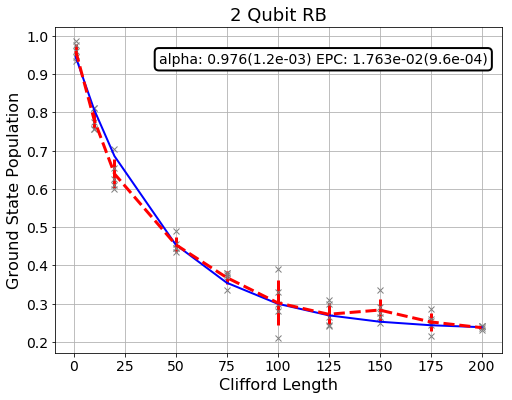

In [8]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

### The intuition behind RB

The depolarizing quantum channel has a parameter $\alpha$, and works like this: with probability $\alpha$, the state remains the same as before; with probability $1-\alpha$, the state becomes the totally mixed state, namely:

$$\rho_f = \alpha \rho_i + \frac{1-\alpha}{2^n} * \mathbf{I}$$

Suppose that we have a sequence of $m$ gates, not necessarily Clifford gates, 
where the error channel of the gates is a depolarizing channel with parameter $\alpha$ 
(same $\alpha$ for all the gates). 
Then with probability $\alpha^m$ the state is correct at the end of the sequence, 
and with probability $1-\alpha^m$ it becomes the totally mixed state, therefore:

$$\rho_f^m = \alpha^m \rho_i + \frac{1-\alpha^m}{2^n} * \mathbf{I}$$

Now suppose that in addition we start with the ground state; 
that the entire sequence amounts to the identity; 
and that we measure the state at the end of the sequence with the standard basis. 
We derive that the probability of success at the end of the sequence is:

$$\alpha^m + \frac{1-\alpha^m}{2^n} = \frac{2^n-1}{2^n}\alpha^m + \frac{1}{2^n} =  A_0\alpha^m + B_0$$

It follows that the probability of success, aka fidelity, decays exponentially with the sequence length, with exponent $\alpha$.

The last statement is not necessarily true when the channel is other than the depolarizing channel. However, it turns out that if the gates are uniformly-randomized Clifford gates, then the noise of each gate behaves on average as if it was the depolarizing channel, with some parameter that can be computed from the channel, and we obtain the exponential decay of the fidelity.

Formally, taking an average over a finite group $G$ (like the Clifford group) of a quantum channel $\bar \Lambda$ is also called a *twirl*:
$$ W_G(\bar \Lambda) \frac{1}{|G|} \sum_{u \in G} U^{\dagger} \circ  \bar \Lambda \circ U$$
Twirling over the entire unitary group yields exactly the same result as the Clifford group. The Clifford group is a *2-design* of the unitary group.

## Simultaneous Randomized Benchmarking


RB is designed to address fidelities in multiqubit systems in two ways. For one, RB over the full $n$-qubit space
can be performed by constructing sequences from the $n$-qubit Clifford group. Additionally, the $n$-qubit space
can be subdivided into sets of qubits $\{n_i\}$ and $n_i$-qubit RB performed in each subset simultaneously [4]. 
Both methods give metrics of fidelity in the $n$-qubit space. 

For example, it is common to perform 2Q RB on the subset of two-qubits defining a CNOT gate while the other qubits are quiescent. As explained in [4], this RB data will not necessarily decay exponentially because the other qubit subspaces are not twirled. Subsets are more rigorously characterized by simultaneous RB, which also measures some level of crosstalk error since all qubits are active.

An example of simultaneous RB (1Q RB and 2Q RB) can be found in: 
https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/ignis/randomized_benchmarking.ipynb

## Predicted Gate Fidelity

If we know the errors on the underlying gates (the gateset) we can predict the fidelity. First we need to count the number of these gates per Clifford. 

Then, the two qubit Clifford gate error function gives the error per 2Q Clifford. It assumes that the error in the underlying gates is depolarizing. This function is derived in the supplement to [5]. 

In [9]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = rb.rb_utils.gates_per_clifford(qobj_list, xdata[0],basis_gates, rb_opts['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per Clifford: %f"%(basis_gates[i],
                                                 np.mean([gates_per_cliff[0][i],gates_per_cliff[1][i]])))

Number of u1 gates per Clifford: 0.248581
Number of u2 gates per Clifford: 0.953712
Number of u3 gates per Clifford: 0.487991
Number of cx gates per Clifford: 1.501965


In [10]:
# Prepare lists of the number of qubits and the errors
ngates = np.zeros(7)
ngates[0:3] = gates_per_cliff[0][0:3]
ngates[3:6] = gates_per_cliff[1][0:3]
ngates[6] = gates_per_cliff[0][3]
gate_qubits = np.array([0, 0, 0, 1, 1, 1, -1], dtype=int)
gate_errs = np.zeros(len(gate_qubits))
gate_errs[[1, 4]] = dp/2 #convert from depolarizing error to epg (1Q)
gate_errs[[2, 5]] = 2*dp/2 #convert from depolarizing error to epg (1Q)
gate_errs[6] = dp*3/4 #convert from depolarizing error to epg (2Q)

#Calculate the predicted epc
pred_epc = rb.rb_utils.twoQ_clifford_error(ngates,gate_qubits,gate_errs)
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 1.706295e-02
